# Just how good is Lewis Hamilton?

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import matplotlib
import warnings
import seaborn as sns
from datetime import datetime
from datetime import timedelta

## Preprocessing Quali Data

### Read data and join dataframes

In [59]:
df_drivers = pd.read_csv("newdb/drivers.csv")
df_races = pd.read_csv("newdb/races.csv")
df_constructors = pd.read_csv("newdb/constructors.csv")
df_qualis = pd.read_csv("newdb/qualifying.csv")

df_qualis = (df_qualis \
             .join(df_drivers.set_index('driverId'), on='driverId', how='left', lsuffix='', rsuffix='_right') \
             .drop(columns=['nationality', 'url', 'dob']) \
             .join(df_races.set_index('raceId'), on='raceId', how='left', lsuffix='', rsuffix='_right') \
             .drop(columns=['time', 'url']) \
             .join(df_constructors.set_index('constructorId'), on='constructorId', how='left', lsuffix='', rsuffix='_right') \
             .drop(columns=['name_right', 'nationality', 'url']))

### Convert best laptimes to date format and then to seconds

In [60]:
for key in ['q1', 'q2', 'q3']:
    q = df_qualis[key].apply(lambda x: '5:0.0' if x == '\\N' else x)
    q[q.isnull()] = '5:0.0'
    q = q.apply(lambda x: datetime.strptime(str(x).split(',')[0],'%M:%S.%f'))
    q = q.apply(lambda x: timedelta(minutes=x.minute,seconds=x.second, milliseconds= x.microsecond / 1000).total_seconds())
    df_qualis[key] = q 
    
best = df_qualis.apply(lambda x: np.min([x['q1'], x['q2'], x['q3']]) , axis=1)
df_qualis['best_q'] = best

We know that sometimes in F1 it's not easy to make fair comparisons among drivers, but considering a driver's teammate seems like a a reasonable and natural way to do so (yet we might agree that in some circumstances even this approach doesn't get rid of all possible noise, for example teams might overfit the design of their car favoring one of their drivers' driving style).

That being said, we can quickly think of at least two aspects to take into account when comparing drivers: Race peace and Qualifying performance. To assess the later, commonly we count the times one driver out-qualifies the other. Then using the Ergast Dataset (https://ergast.com/mrd/db/#csv) I came up withe following graph (note that if any driver didn't set a lap time during a session, that instance was ignored for both of them).

<Figure size 1500x900 with 0 Axes>

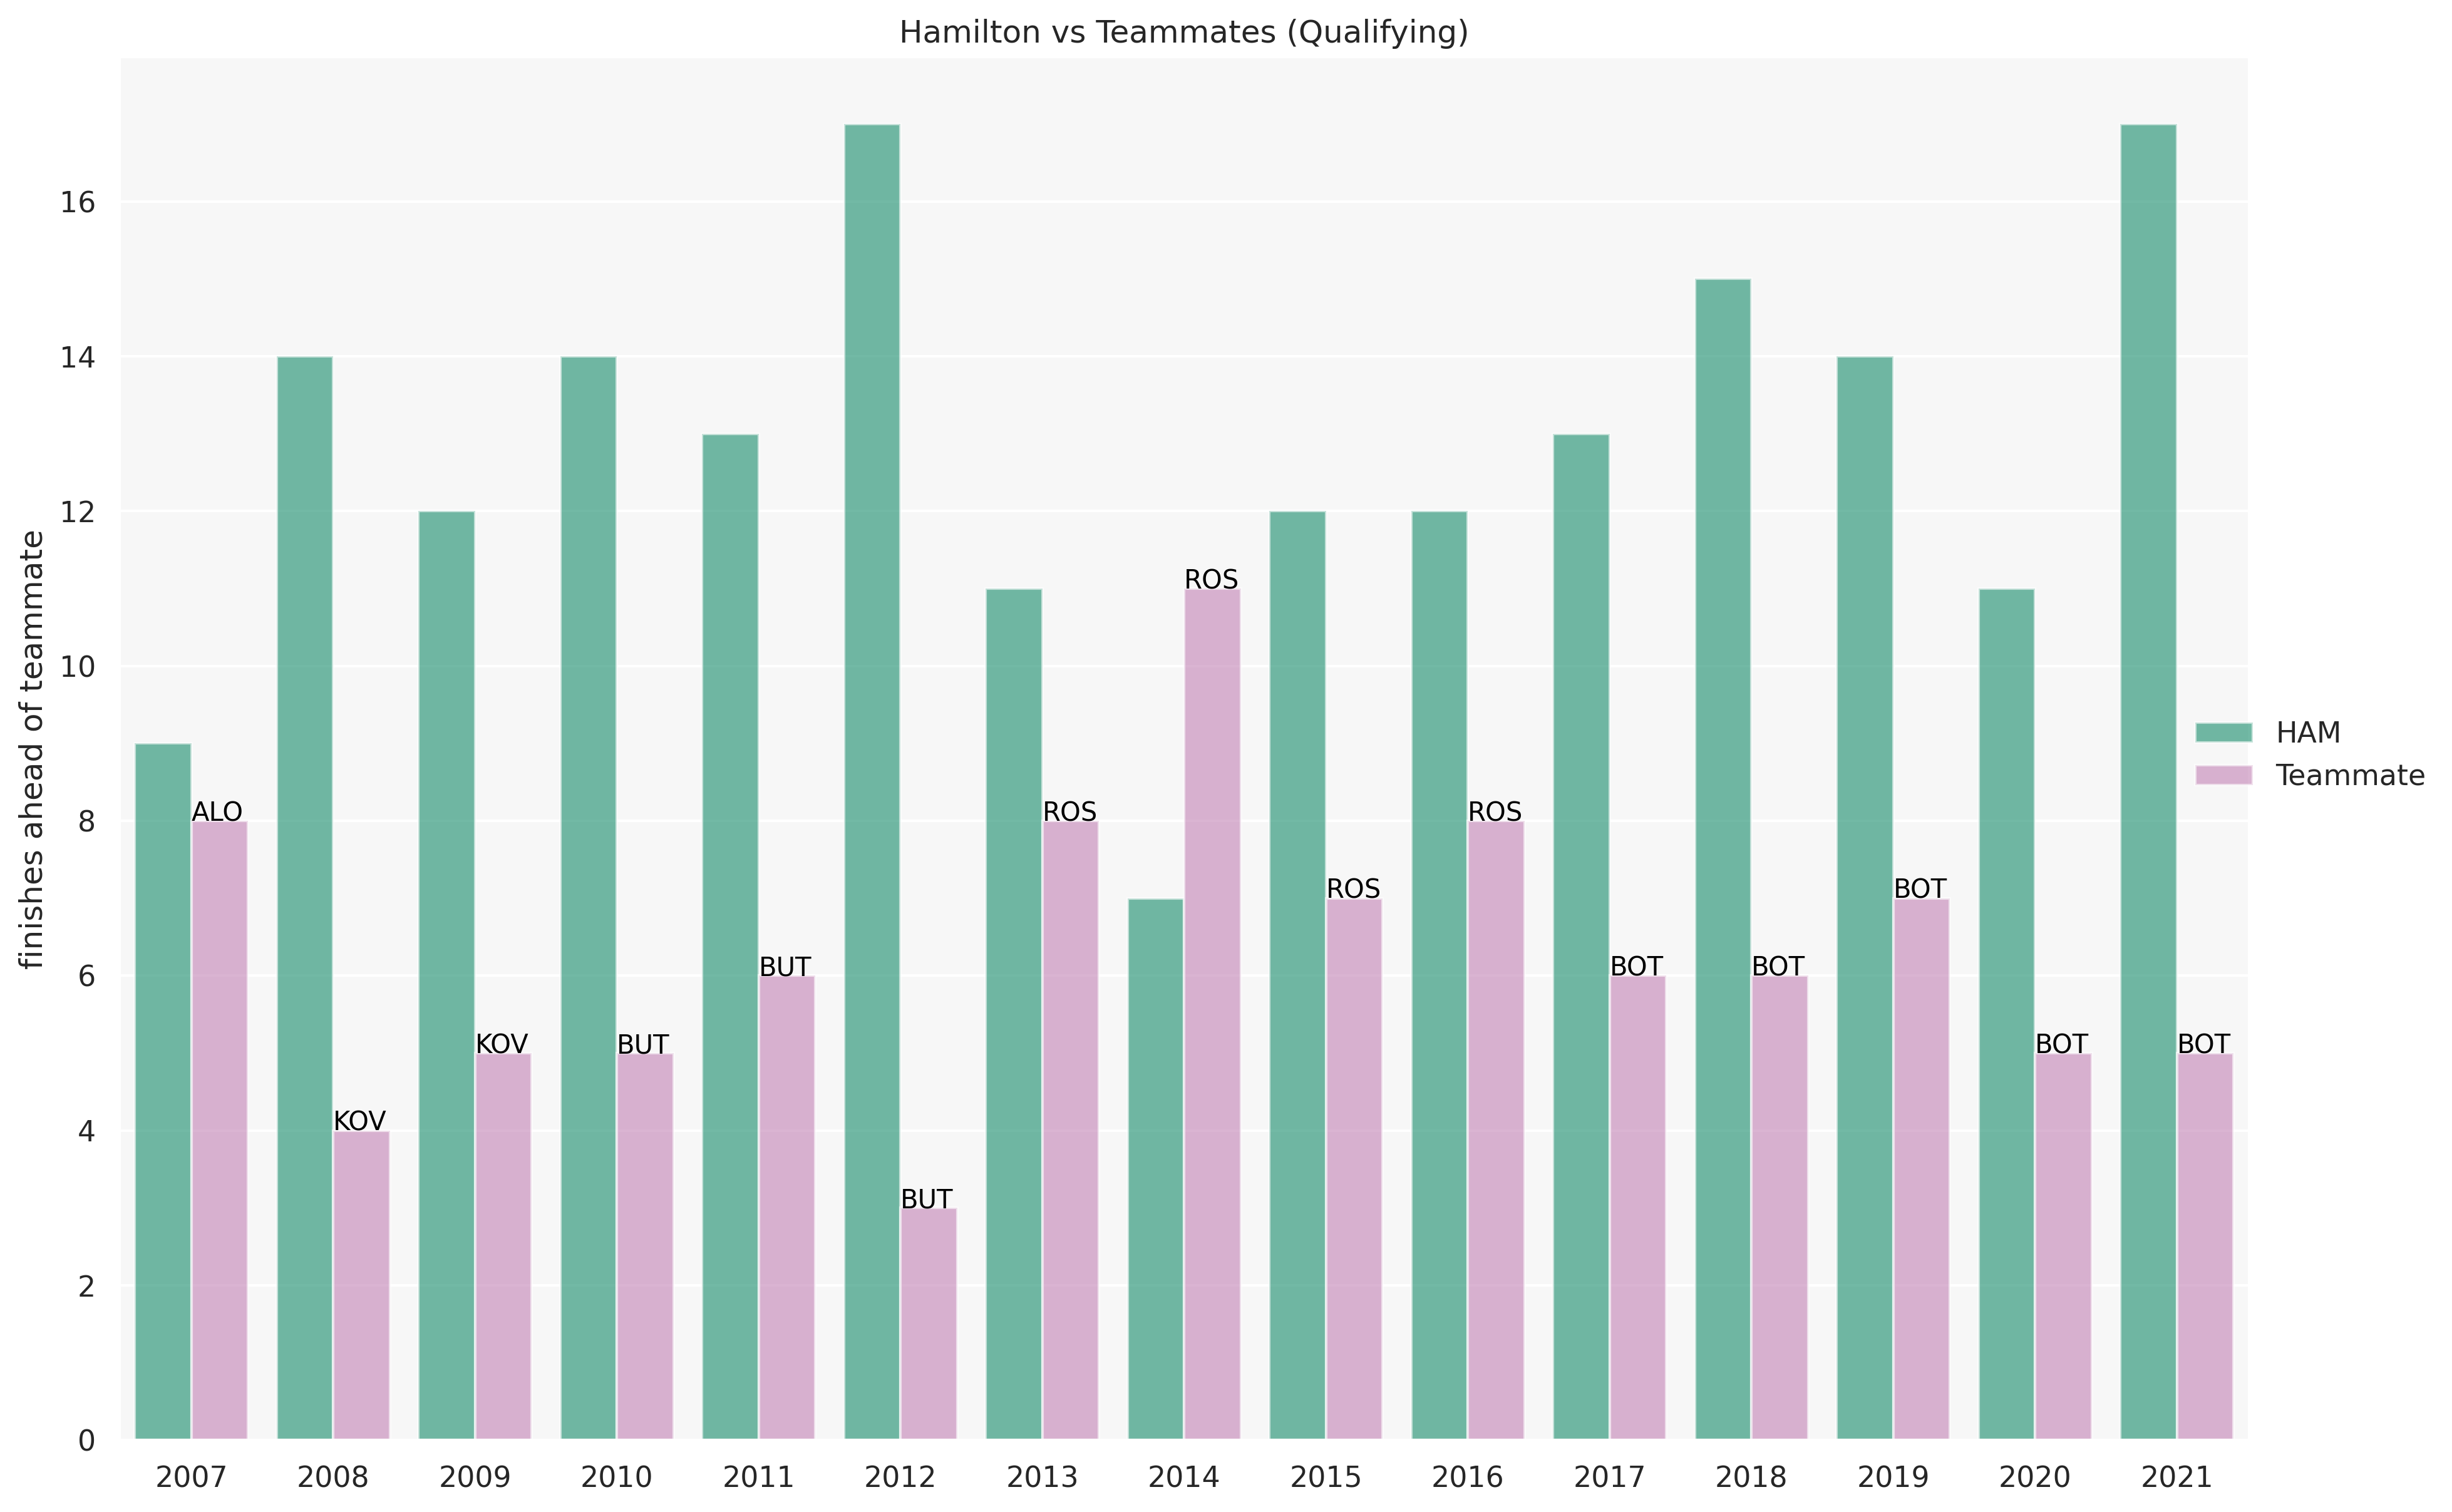

In [51]:
# Teammates
ham_teammates = {'ALO': [2007], 'KOV': [2008,2009], 'BUT': [2010,2011,2012],
              'ROS': [2013,2014,2015,2016], 'BOT':[2017,2018,2019,2020,2021]}


isRival = df_qualis.apply(lambda row: (row['code'] == 'HAM' or (row['code'] in ham_teammates and 
                                                                row['year'] in ham_teammates[row['code']])),axis=1)

df_rivals  = df_qualis[isRival]
filter_dnfs = (df_rivals['best_q'] == 300) 
ids_dnfs = df_rivals[filter_dnfs]['raceId']
filter_dnf = ~(df_rivals['raceId'].isin(ids_dnfs) | (df_rivals['raceId'] == 1046))
df_rivals = df_rivals[filter_dnf] 

def outquali(x):
    if x['code'] == 'HAM':
        rival = ham_rivals_year[x['year']]
    else:
        rival = 'HAM'
    rival_pos = df_rivals[(df_rivals['code'] == rival) & (df_rivals['raceId'] == x['raceId'])]['position']
    return int(x['position']) < int(rival_pos)

ham_rivals_year = {}
for key, values in ham_rivals.items():
    for v in values:
        ham_rivals_year[v] = key
    
df_outq = df_rivals[df_rivals['year'] < 2022]
df_outq['outq'] = df_outq.apply(lambda x: outquali(x) ,axis=1)
df_outq['isRival'] = df_outq['code'] != 'HAM'
df_outq = df_outq.groupby(['year', 'code', 'surname', 'constructorRef','isRival'])['outq'].sum().reset_index()


# Plot
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
matplotlib.rcParams['figure.dpi'] = 300
sns.set(rc={"axes.facecolor":    (0.0, 0, 0.0, 0.03),
            "savefig.facecolor": (0.0, 0.0, 0, 0.03)})

my_palette = sns.color_palette("colorblind", 10)

plt.figure(figsize=(5,3))
g = sns.catplot(
    data=df_outq, kind="bar",
    x="year", y="outq", hue="isRival",
    ci=None, palette= sns.color_palette([my_palette[2], my_palette[4]]),
    alpha=.6, aspect=1.5,height=8,facet_kws={'legend_out': True})

g.despine(left=True)
g.set_axis_labels("", "finishes ahead of teammate")
plt.title('Hamilton vs Teammates (Qualifying)')

# Title
new_title = ''
g._legend.set_title(new_title)
new_labels = ['HAM', 'Teammate']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
    
# Legends   
text = ['ALO', 'KOV', 'KOV', 'BUT', 'BUT', 'BUT', 'ROS', 'ROS', 
        'ROS', 'ROS', 'BOT', 'BOT', 'BOT', 'BOT','BOT']

ax = g.facet_axis(0,0)
for i, p in enumerate(ax.patches):
    s = '' if i < 15 else text[i-15]
    ax.text(p.get_x(), p.get_height(), s, color='black',
            rotation='horizontal', size='small')

plt.savefig("test.png", dpi=100)


This way, Hamilton's dominance becomes evident, portraying him as a strong "one lap" driver. His performance during the McLaren saga (2007-2013) is stunning, beating remarkable drivers like Alonso, Button and Rosberg.
The 2007 season, clearly the tightest in the Mclaren saga, was a very special one. For him it was his debut season in F1 and his opportunity to shine in a car that happened to be one of the best, if not the best car on the grid that year (followed closely by Kimi's Ferrari). Help me out here but I can't think of many rookies that went through the same situation: Jacques Villeneuve is the first one that comes to my mind, who debuted in 1996 in a championship winning car and finished second three points behind his teammate Damon Hill. Really impressive. Next year he went on to be the World Champion beating ferrari (just like Hamilton did in 2008). However in 1996 he wasn't as close to Damon's Qualifying performance.

So Ron Denis gave him probably the best car on the grid for his rookie season, but to spice things up a bit he paired HAM against Alonso, one of the greatest drivers in mordern Formula 1. If that's not enough of a "warm up" season, let's add some spygate scandal.

As for his Mercedes saga, he only lost once and it was at the start of the hybrid era in 2014 against Rosberg after beating him in 2013 in his Mercerdes debut. Interestingly, he defeated Rosberg the only season he didn't get the title with Mercedes (2016).
All these comparisons are ok but the chosen metric could be a bit opaque, leaving many details behind. Does Hamilton go much faster than his teammate in qualifying?

So to dive in further into this we'll consider the average qualifying gap against his teammates. Sessions where any of the drivers didn't set a lap time, again, will be ignored. The gap for a session will be computed as the difference between each driver's best lap time set any time during the session (q1, q2 , q3). Now, of course this new metric can fall short as it ignores the subtleties that often play a role in quali sessions and we could be overestimating his performance.


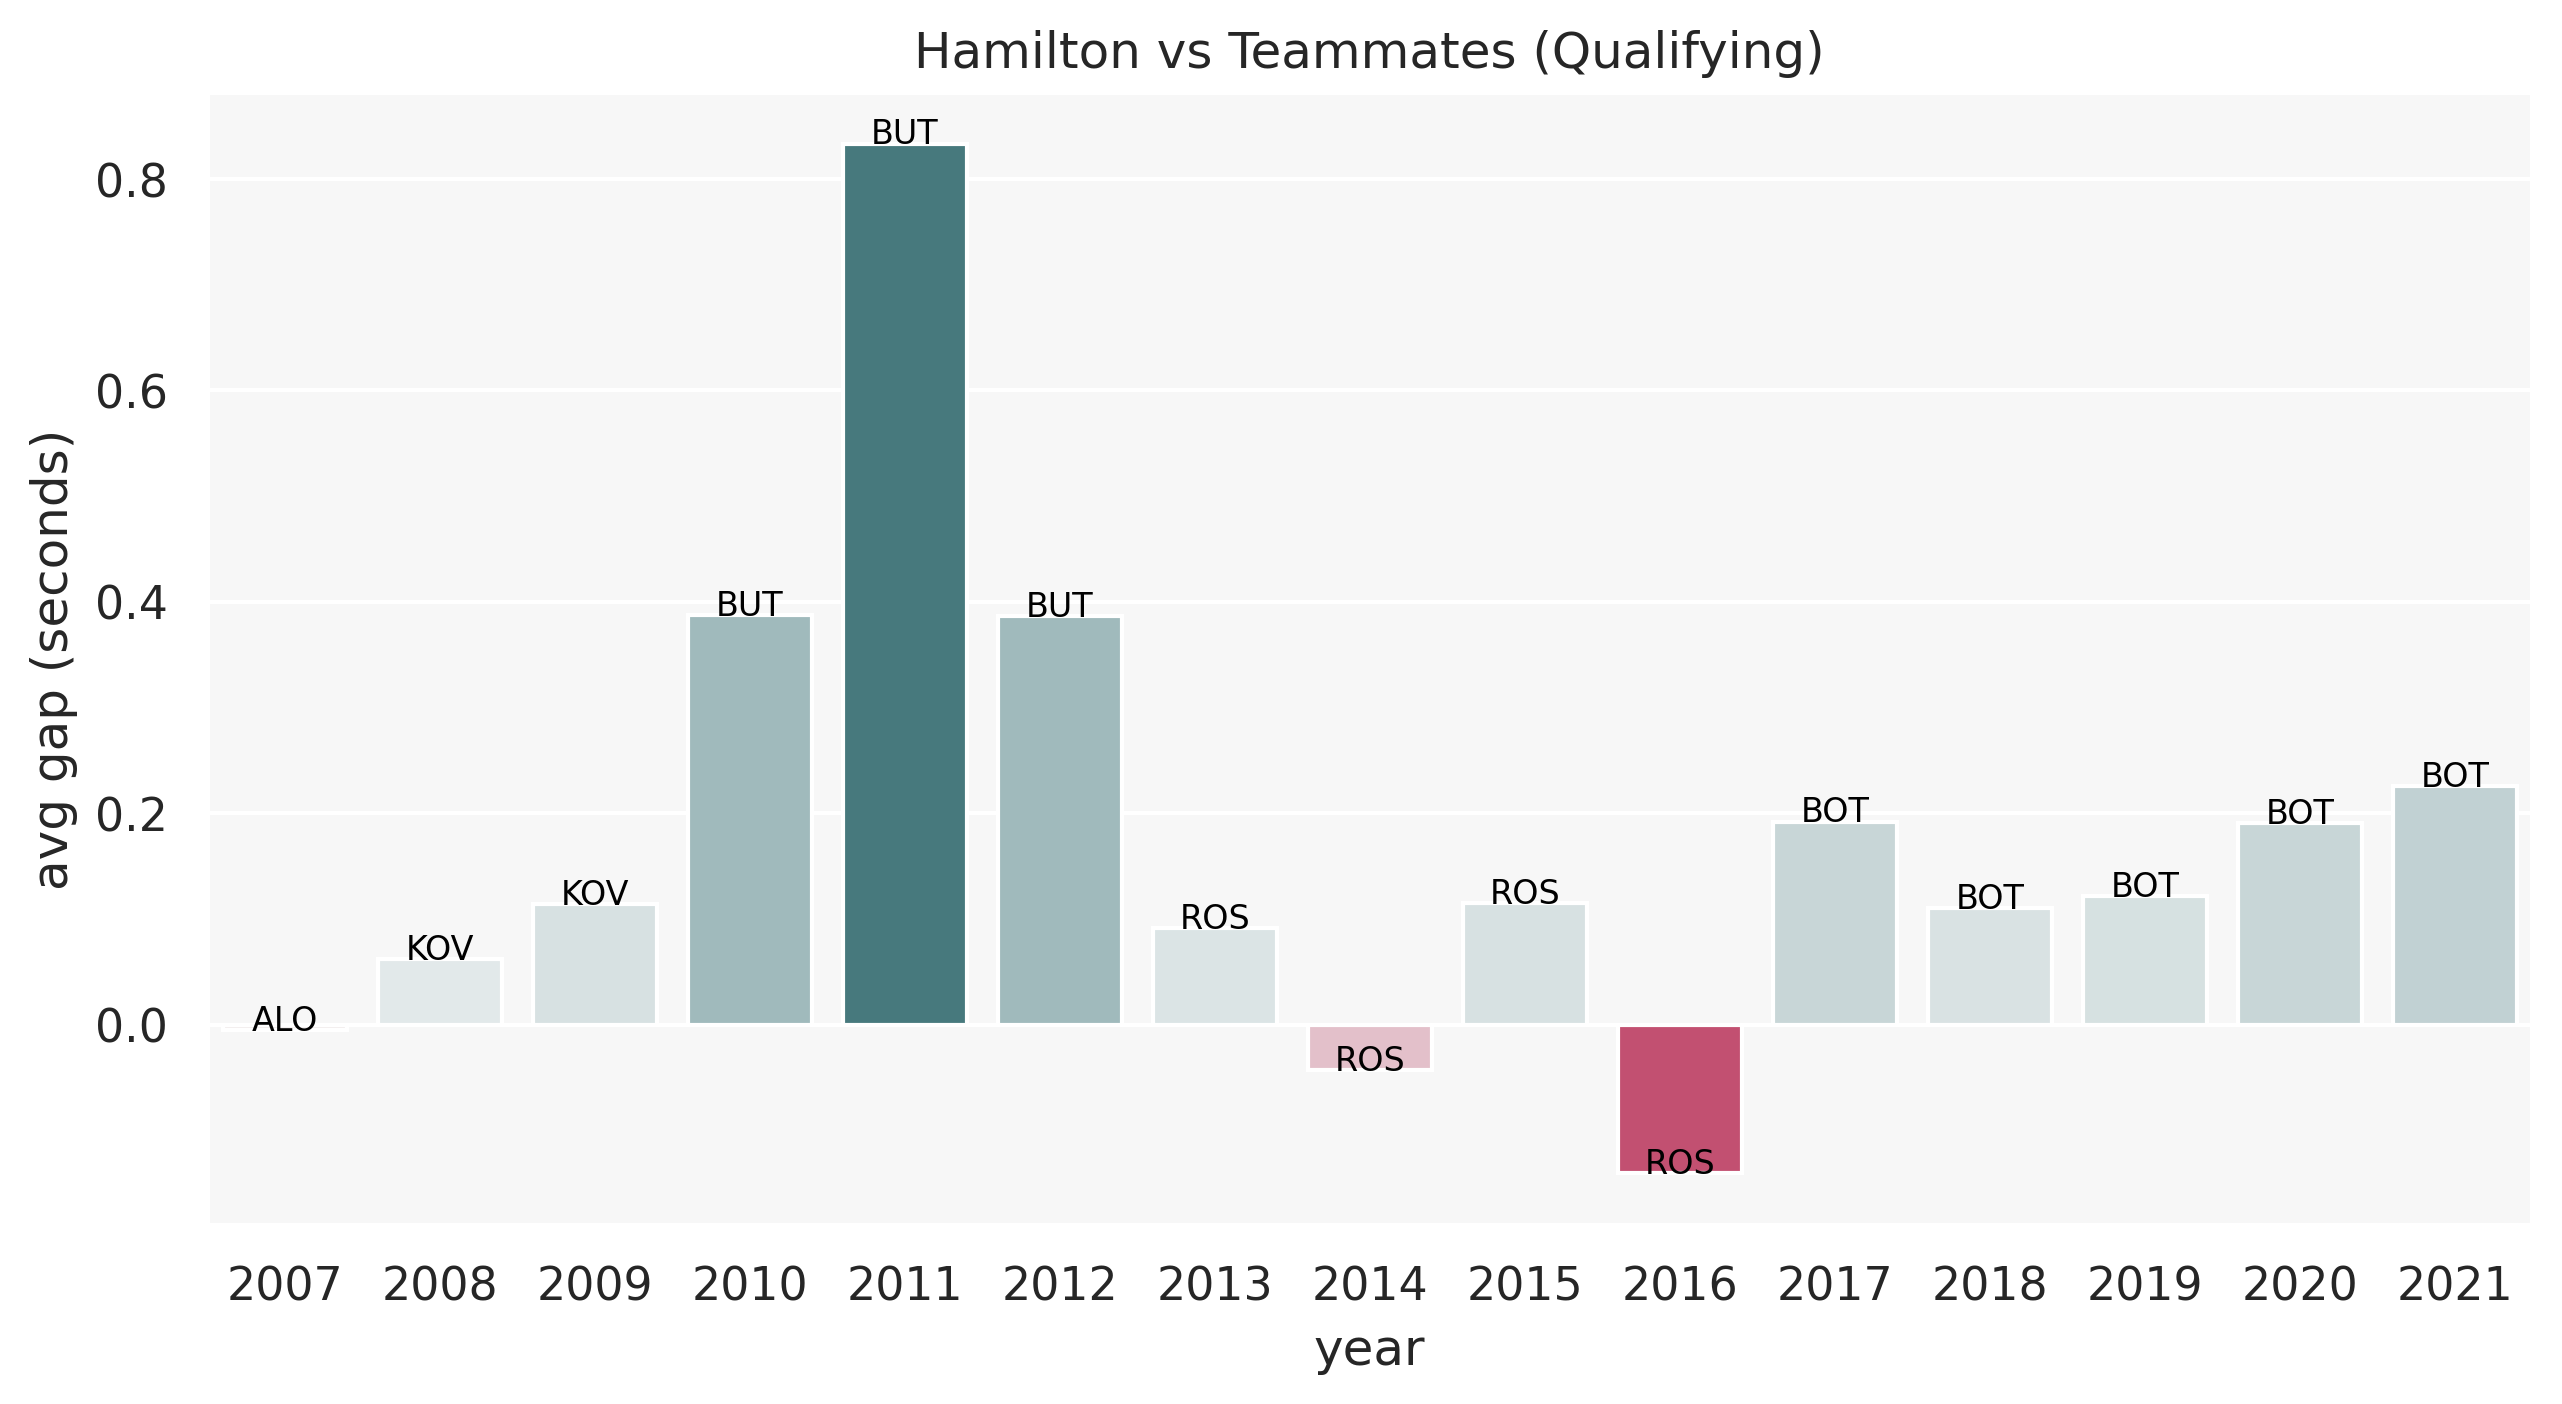

In [62]:
from matplotlib.colors import DivergingNorm

def center(x):
    ham = df_rivals[(df_rivals['code'] == 'HAM') & (df_rivals['year'] == x['year'])]
    a = float( x['best_q'] - ham['best_q'])
    return a 

df_rivals = df_rivals.groupby(['year', 'code', 'surname', 'constructorRef'])['best_q'].mean().reset_index()
df_rivals['gap'] = df_rivals.apply(lambda x: center(x), axis=1)
df_rivals = df_rivals[df_rivals['code'] != 'HAM']


# Plot
plt.figure(figsize=(10,5))
norm = DivergingNorm(vmin=df_rivals.gap.min(), vcenter=0, vmax=df_rivals.gap.max())
red_green_pal = sns.diverging_palette(0, 200, n=256, as_cmap=True)
colors = [red_green_pal(norm(c)) for c in df_rivals['gap']]
ax = sns.barplot(x="year", y="gap", palette=colors, ci=None, data=df_rivals)

# Title and Legends
plt.title('Hamilton vs Teammates (Qualifying)')
ax.set(xlabel='year', ylabel='avg gap (seconds)')

for index, row in df_rivals.iterrows():
    ax.text(row.year - 2007 ,float(row.gap), row.code, color='black', ha='center', fontsize=8)

plt.show()




Once again we can see how absurdly close Hamilton and Alonso were during that season (0.005 is the actual difference in favor of Alonso). Note that although he outclassifed Rosberg in 2016, he was slower on average by a fine margin.
Also, the rivalry between ROS and HAM was notably close and the gap was never greater that 0.15s.

This graph keeps showing HAM's outstanding performance in Mclaren, in particular against BUT. I was surprised to see Kovalainen not so far off!

To sum things up, the average gap against his teammates during his entire career is 0.17 +- 0.22.

Now what we can do is to see how distant Hamilton's average pace in Qualifying is from the rest of the grid. Those years where he didn't have the best car overall should be interesting. I'll use the same methodology as before, getting rid of the events where any driver didn't manage to set a lap time during a session. I realized this was a pretty strong decision as 57 events were removed this way from 2007 to 2020.

In [63]:
df_all  = df_qualis[df_qualis['year'] >= 2007]

# Filter top10 in Wdc
filter_dnfs = (df_all['best_q'] == 300) 
ids_dnfs = df_all[filter_dnfs]['raceId']

filter_dnf = ~(df_all['raceId'].isin(ids_dnfs) | (df_all['raceId'] == 1046))
df_all = df_all[filter_dnf] 

total = df_all.groupby(['year', 'code', 'surname', 'constructorRef'])['best_q'].nunique().reset_index()['best_q']
df_all = df_all.groupby(['year', 'code', 'surname', 'constructorRef'])['best_q'].mean().reset_index()
df_all['total'] = total

ham_all = df_all[df_all['code']  == 'HAM']

def same_as_ham(x):
    a = int(x['total']) == int(ham_all[ham_all['year'] == x['year']]['total'])
    return a

def center(x):
    ham = ham_all[ham_all['year'] == x['year']]
    a = float( x['best_q'] - ham['best_q'])
    return a 

df_all = df_all[df_all.apply(lambda x: same_as_ham(x), axis=1)]
df_all['gap'] = df_all.apply(lambda x: center(x) ,axis=1)


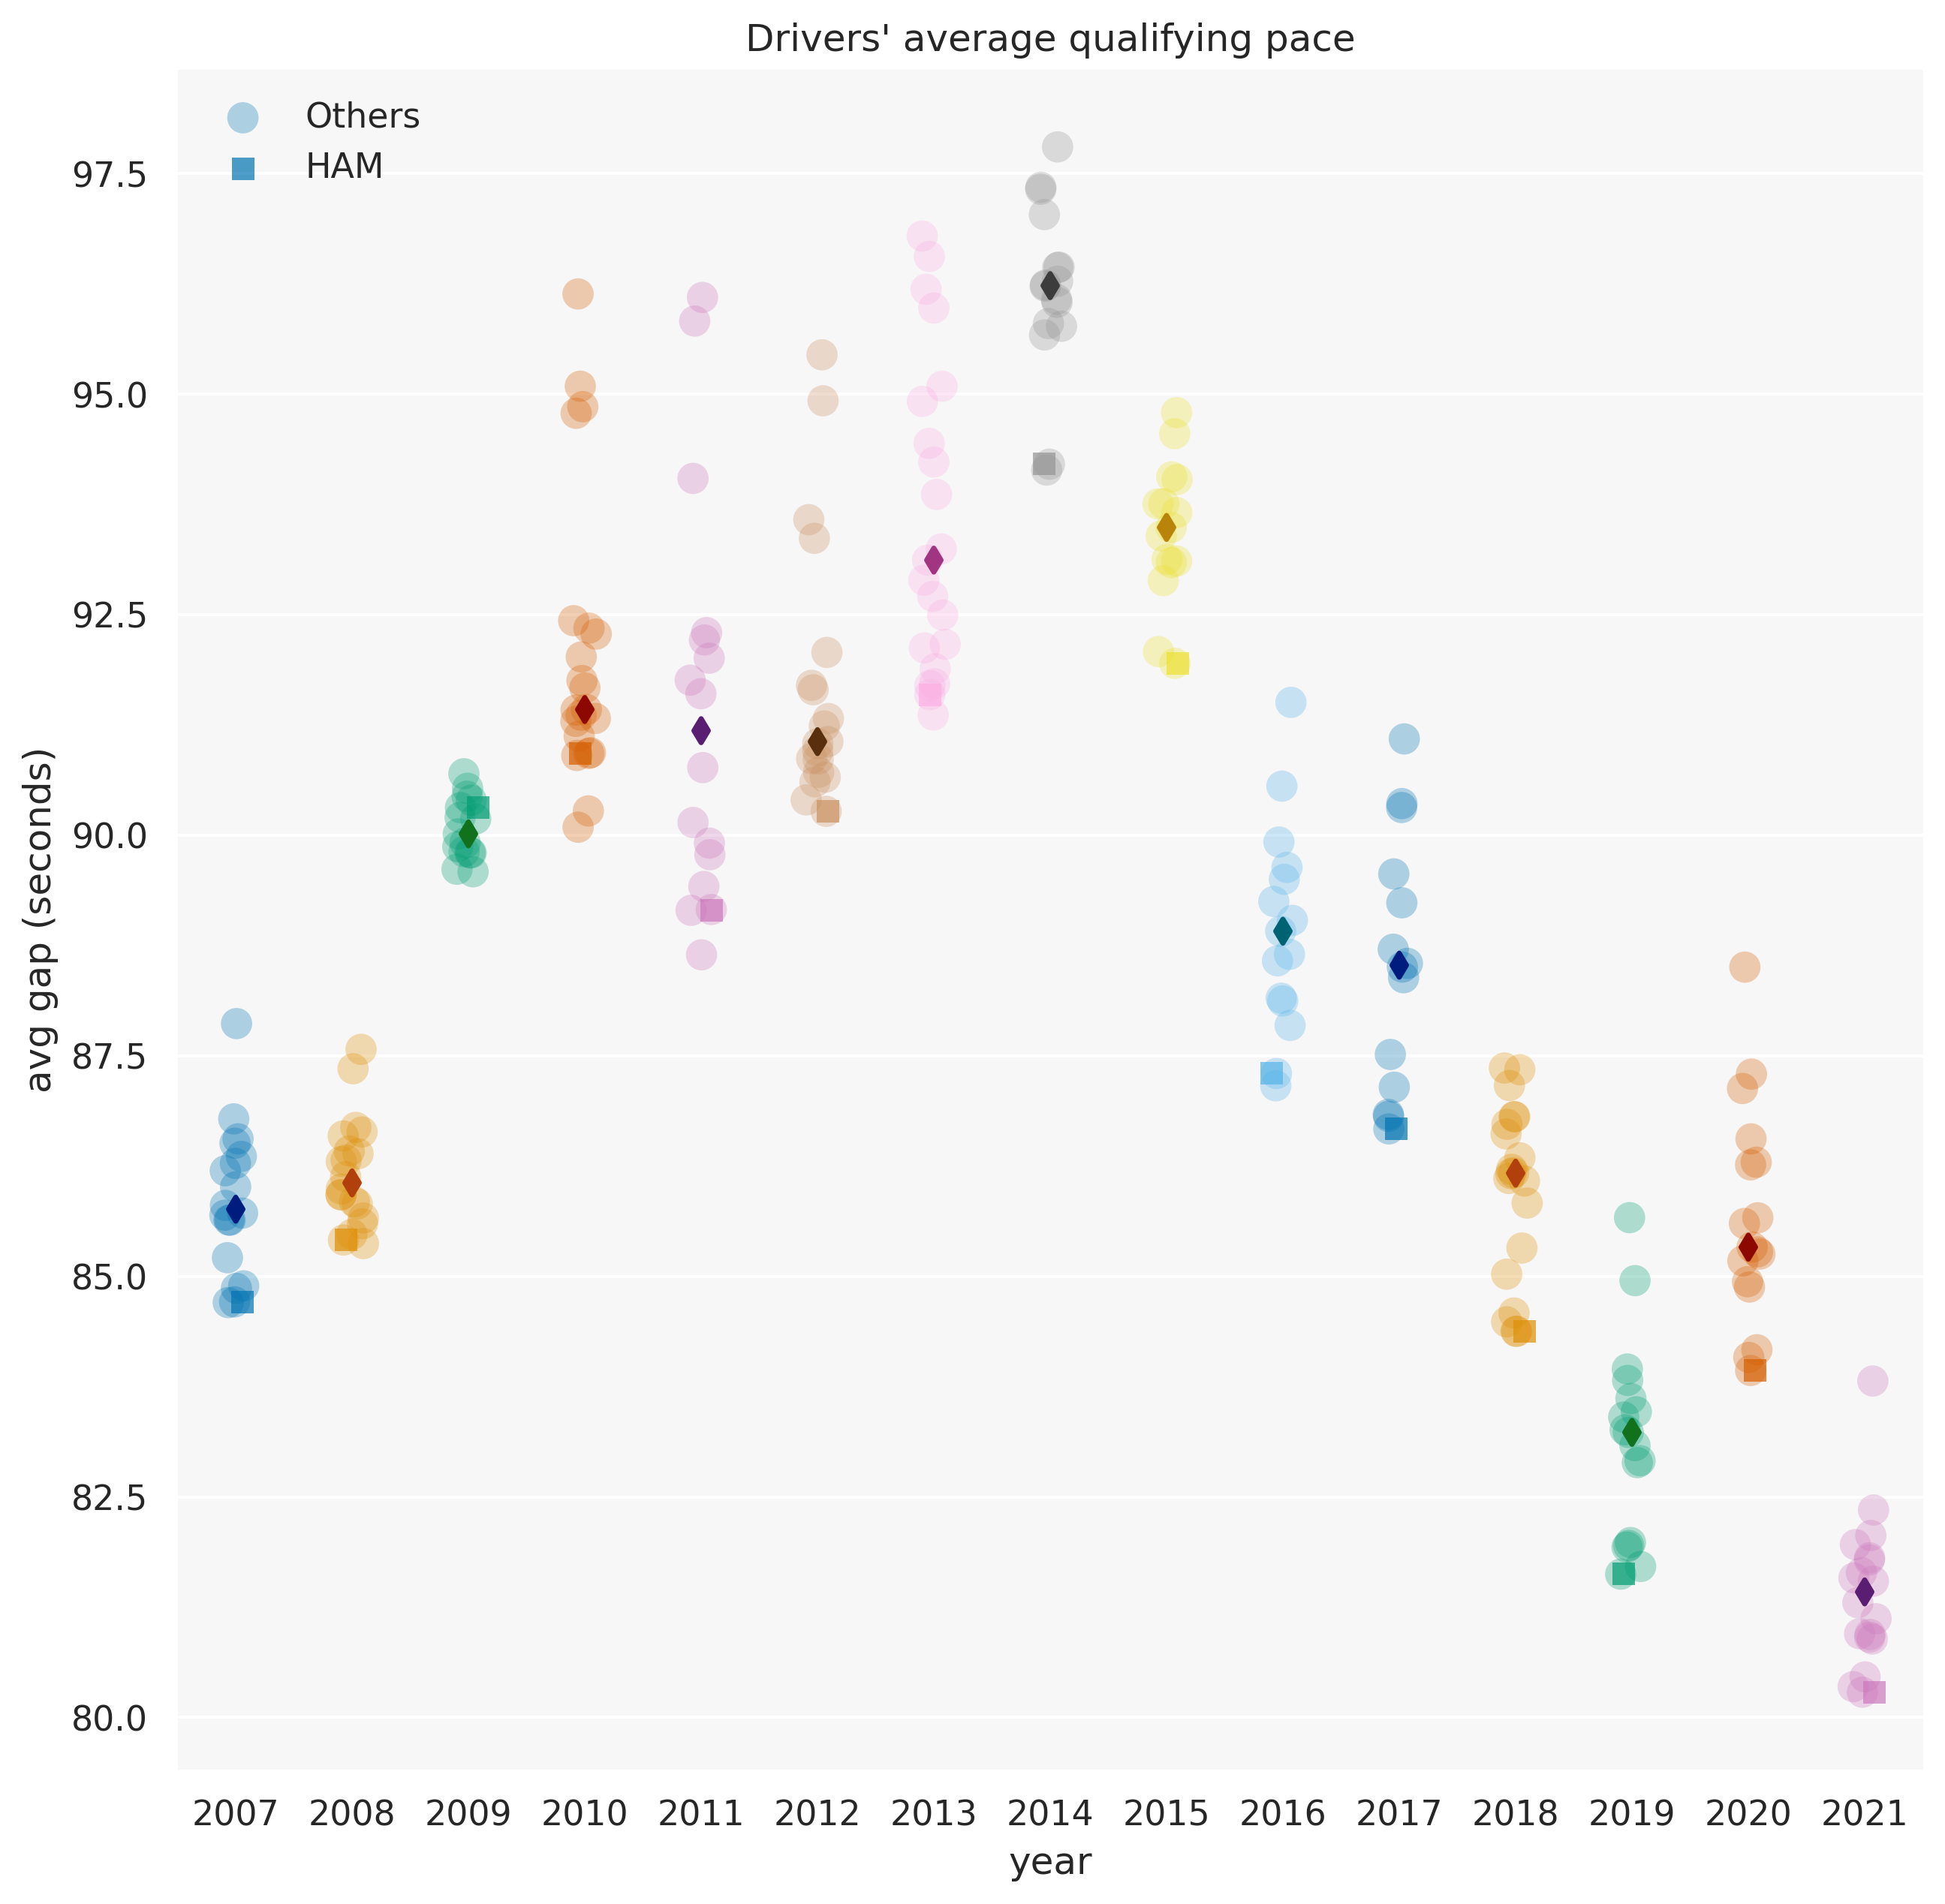

In [64]:
# Plot
sns.set(rc={"axes.facecolor":    (0.0, 0, 0.0, 0.03),  # green with alpha = 50%
            "savefig.facecolor": (0.0, 0.0, 0, 0.03),
           'legend.frameon': False})
df_all  =  df_all[df_all['year'] < 2022]


ham_points = df_all[df_all['code'] == "HAM"]['best_q']
years = df_all['year'].unique()

f, ax = plt.subplots(figsize=(10,10))
sns.despine(bottom=True, left=True)

ax  = sns.stripplot(x="year", y="best_q",data=df_all, label="Others", palette='colorblind',
                    jitter=True, dodge=True, alpha=0.3, zorder=1,size=10)
ax2 = sns.stripplot(x=years, y=ham_points, dodge=True, label="HAM",palette='colorblind',
                    zorder=1,size=7,marker='s',alpha=0.7)
ax3 = sns.pointplot(x="year", y="best_q", data=df_all, dodge=.8 - .8 / 3, join=False, 
                    palette="dark", label="Median", markers="d", scale=.8, ci=None, 
                    estimator=np.median, alpha=0.7)

plt.title("Drivers' average qualifying pace")
ax.set(xlabel='year', ylabel='avg gap (seconds)')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[::15], labels[0::15], loc=2)
plt.show()


It's pretty clear Hamilton is consistently among the best qualifiers. Actually, he is only outside of the top2 in just two occasions: 2009(14th) and 2010(4th).

As far as I know 2009 Mclaren had a horrible start of the season as they failed to get a podium until after the first half of the season. However they then recovered to clinch 3rd in the WDC.

Interestingly, that season has the least variance in lap times. HAM, although he is behind the median, is just 0.512s away from BUT(#3). In 2011 HAM(#2) was 0.5s behind Vettel(#1).

In 2007, he was defeated by ALO(#1) by only 0.008s! Those numbers just keep showing how tight the battle between those two was. In 2008, he came second after Massa by just 0.04s. Pretty close as well.

From 2014 to 2016 the graph doesn't add anything new in terms of what we knew about the HAM-ROS rivalry but it lets us see the 1 to 2 second gap the Mercs pulled against the rest of the grid, which is a lot. Then, after 2017, some teams like Red Bull and Ferrari managed to close that gap but HAM always stays on op. Finally, he even defeated VER(#2) in 2021 by 0.06s.


In [ ]:
#for y in df_all['year'].unique():
#    print(df_all[df_all['year'] == y].sort_values(by=['best_q'])[:4])